# Descripción del proyecto

La cadena de supermercados Good Seed está introduciendo un sistema de visión
artificial para procesar las fotos de los clientes. La fotofijación en el área de pago
ayudará a determinar la edad de los clientes para:
Analizar las compras y ofrecer productos que puedan interesar a los compradores
en determinados grupos de edad
Supervisar a los empleados que venden alcohol
Construir un modelo que determinará la edad aproximada de una persona a partir de
una fotografía. Como apoyo, tendrás un conjunto de fotografías de personas indicando
su edad.
Instrucciones

# Tabla de Contenido

* [1. Inicialización](#1)
* [2. Cargar los Datos](#2)
   * [2.1 Conclusiones Intermedias](#2.1)    
* [3 EDA](#3)
    * [3.1 Conclusiones Intermedias](#3.1)    
* [4 Modelado](#4)
* [5. Prepara el script para ejecutarlo en la plataforma GPU](#5)
    * [5.1 El resultado](#5.1)
* [6 Conclusiones](#6)    

## Inicialización

In [1]:
# importamos las librerías

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

plt.style.use('default')

## Carga los datos

El conjunto de datos se almacena en la carpeta `/datasets/faces/` 
- La carpeta `final_files` con 7600 fotos 
- El archivo `labels.csv` con etiquetas, con dos columnas: `file_name` y `real_age` 
Dado que el número de archivos de imágenes es bastante elevado, se recomienda evitar leerlos todos a la vez, ya que esto consumiría muchos recursos computacionales. Te recomendamos crear un generador con ImageDataGenerator. Este método se explicó en el capítulo 3, lección 7 de este curso.

El archivo de etiqueta se puede cargar como un archivo CSV habitual.

In [3]:
path = '/datasets/faces/final_files'

In [4]:
labels = pd.read_csv('/datasets/faces/labels.csv')

In [5]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


In [6]:
labels.head()

file_name  real_age
0  000000.jpg         4
1  000001.jpg        18
2  000002.jpg        80
3  000003.jpg        50
4  000004.jpg        17

In [ ]:
labels.duplicated().sum()

In [7]:
labels.describe()

real_age
count  7591.000000
mean     31.201159
std      17.145060
min       1.000000
25%      20.000000
50%      29.000000
75%      41.000000
max     100.000000

In [8]:
def create_datagen_flow(min_age = 0, max_age = 100):
    
    datagen = ImageDataGenerator(rescale = 1./255)
    
    datagen_flow = datagen.flow_from_dataframe(
        dataframe = labels.query('real_age >= @min_age and real_age <= @max_age'),
        directory = '/datasets/faces/final_files',
        x_col = 'file_name',
        y_col = 'real_age',
        target_size = (240, 240),
        batch_size = 16,
        class_mode = 'raw',
        seed = 12345)
    
    return datagen_flow

### Conclusiones:

* Nos encontramos con un conjunto de datos con 7591 entradas.
* Posee dos columnas, 'file_name' que es de tipo object y 'real_name', de tipo int.
* No se observaron valores ausentes o duplicados.
* Se creo el generador con ImageDataGenerator.

## EDA

In [9]:
dft1 = labels['real_age'].value_counts().sort_index().reindex(np.arange(0, 101)).fillna(0).astype('int')

dft1

0        0
1      149
2       88
3       25
4      101
      ... 
96       2
97       1
98       0
99       0
100      1
Name: real_age, Length: 101, dtype: int64

In [10]:
dft2 = pd.cut(labels['real_age'], np.arange(0, 101, 10), right = False).value_counts().sort_index() 

dft2

[0, 10)       663
[10, 20)     1213
[20, 30)     2075
[30, 40)     1564
[40, 50)      940
[50, 60)      615
[60, 70)      279
[70, 80)      130
[80, 90)       78
[90, 100)      33
Name: real_age, dtype: int64

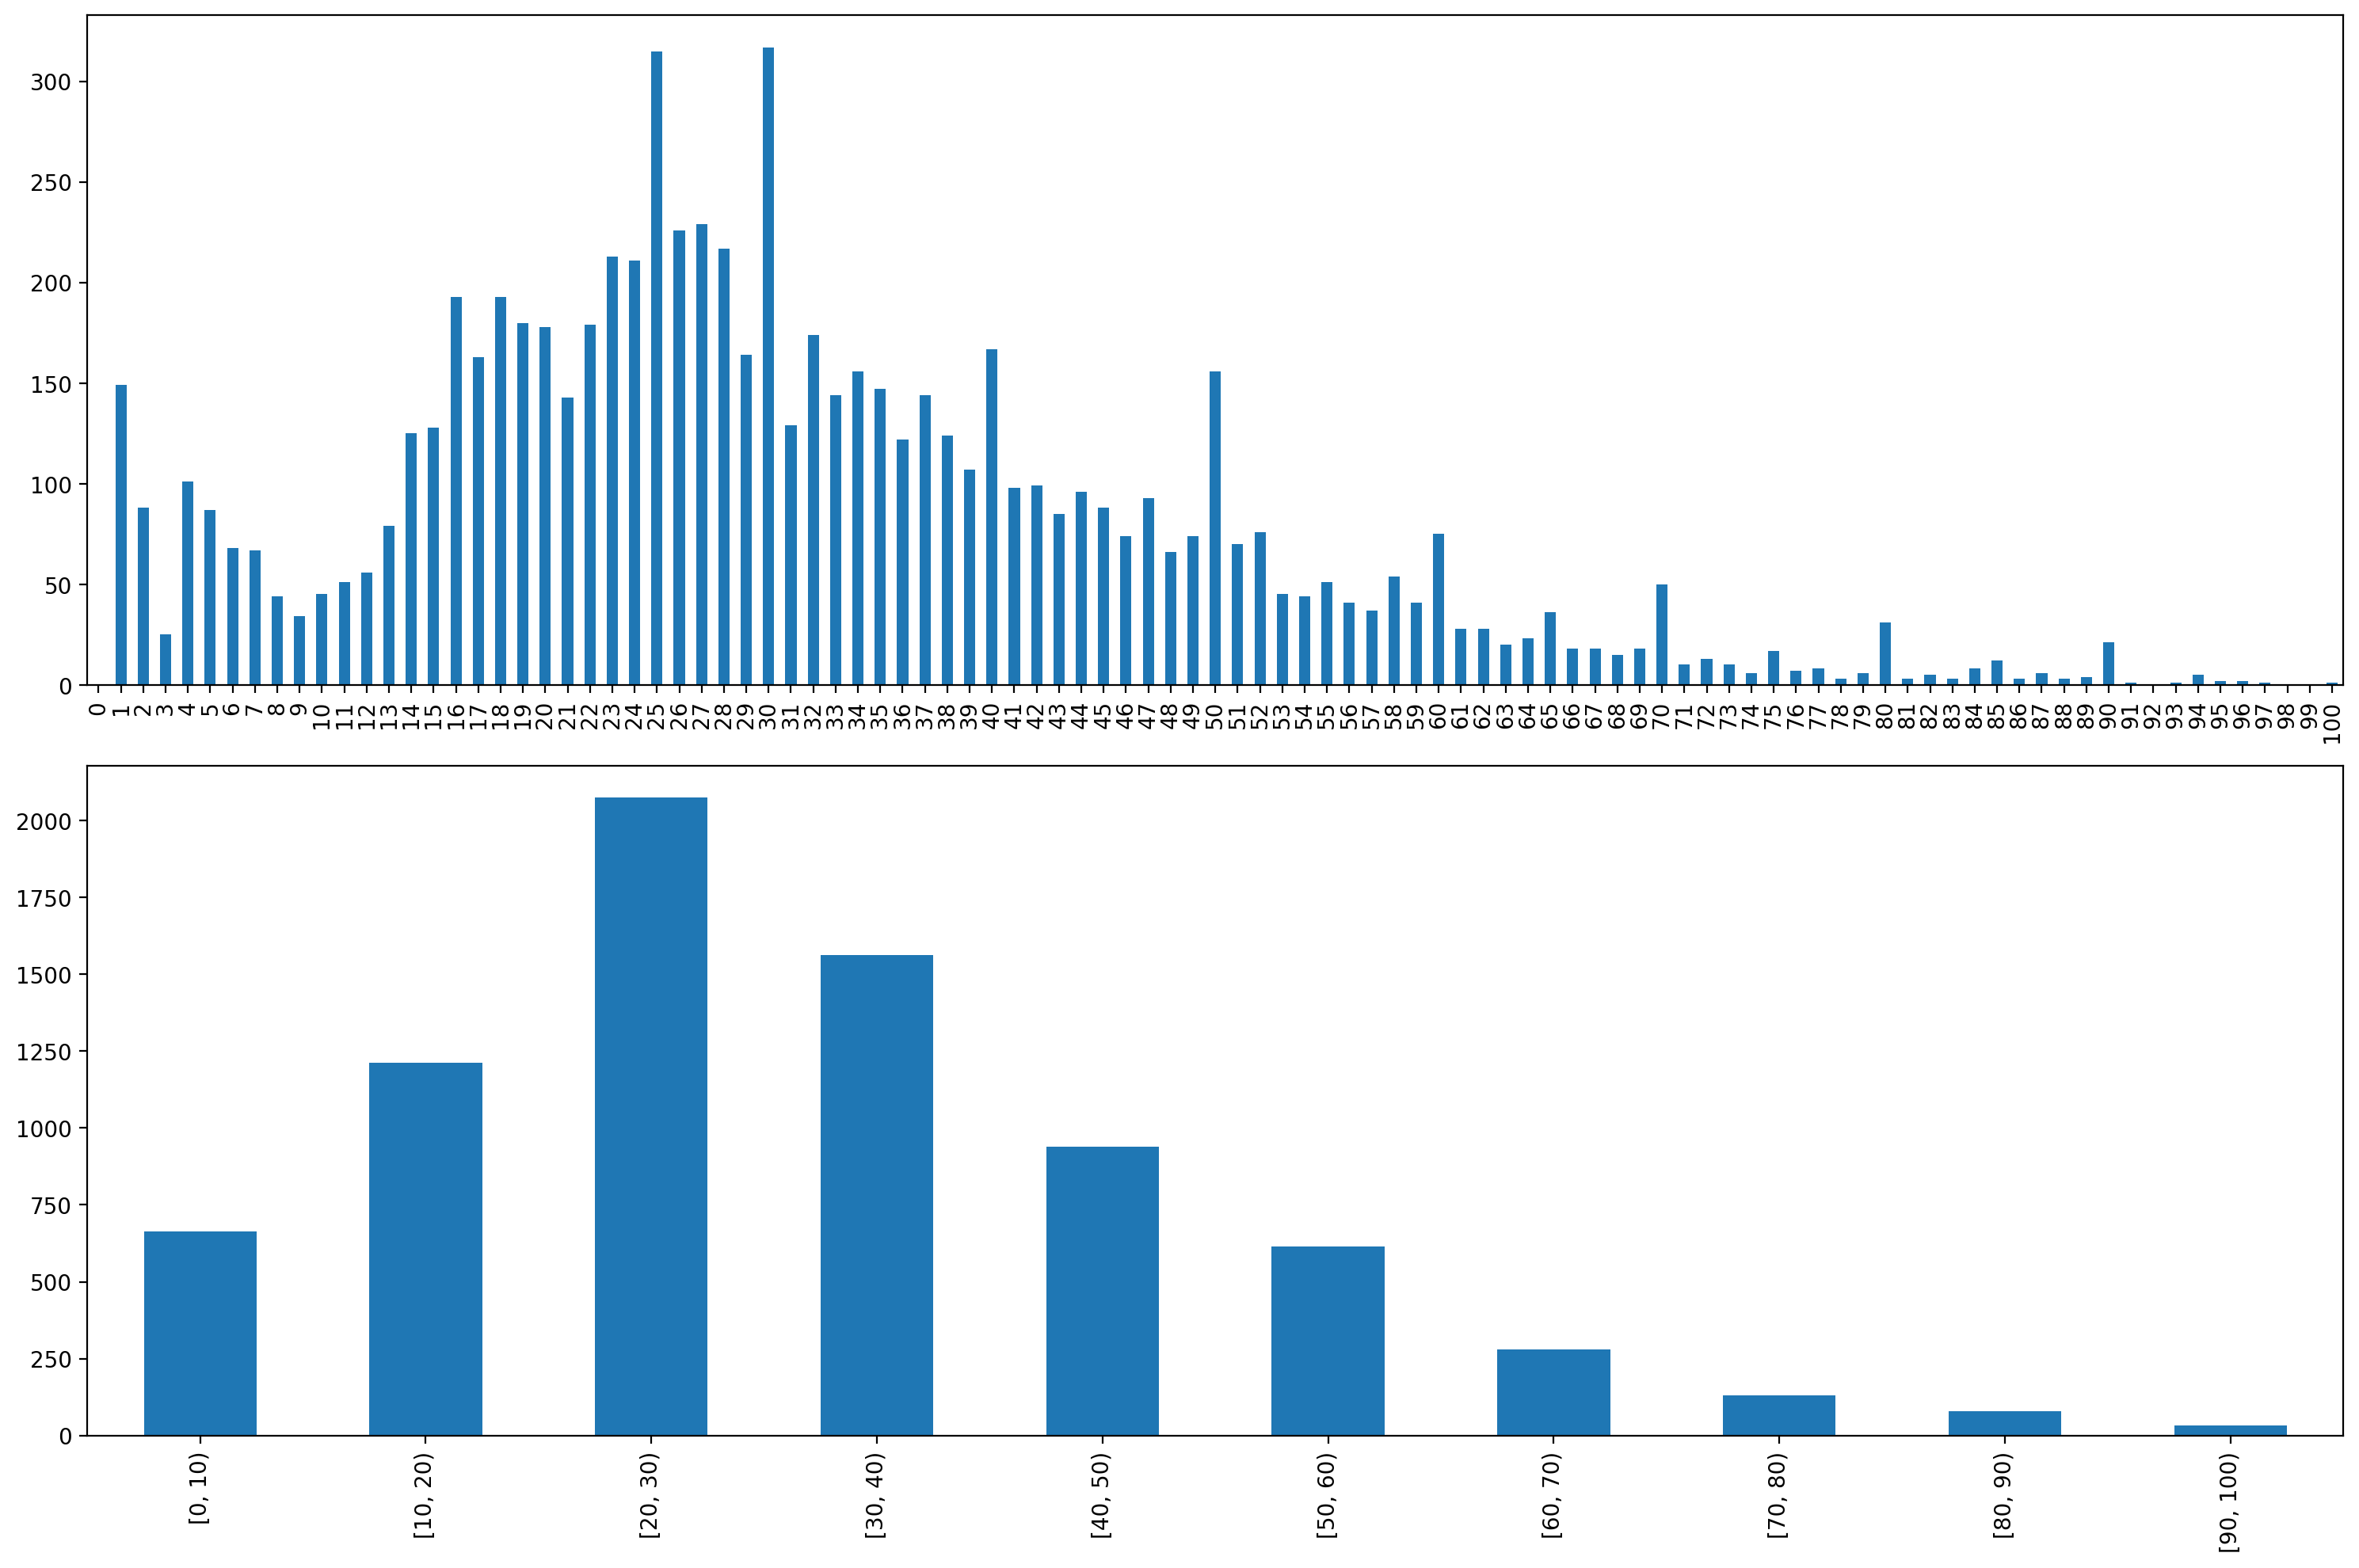

In [11]:
fig, axs = plt.subplots(2, 1, figsize = (15, 10))

ax = axs[0]
dft1.plot(kind = 'bar', ax = ax)

ax = axs[1]
dft2.plot(kind = 'bar', ax = ax)

fig.tight_layout()

In [20]:
def show_batch(batch, predictions=None):
    
    rows = 3
    cols = 5
    fig, axs = plt.subplots(rows, cols, figsize=(10, 6))

    for i in range(15):
        
        row = i // cols
        col = i % cols
        ax = axs[row][col]
        ax.imshow(batch[0][i])
        real_age = batch[1][i]
        if predictions is None:
            title = f'age: {real_age}'
        else:
            title = f'age: {real_age}, pred: {round(predictions[i])}'
        ax.set_title(title, fontsize='medium')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_xticklabels([])
        ax.set_yticklabels([])

    fig.tight_layout()

In [21]:
datagen_flow_0_9 = create_datagen_flow(min_age = 0, max_age = 9)
datagen_flow_10_79 = create_datagen_flow(min_age = 10, max_age = 79)
datagen_flow_80_100 = create_datagen_flow(min_age = 80, max_age = 100)

Found 663 validated image filenames.
Found 6816 validated image filenames.
Found 112 validated image filenames.


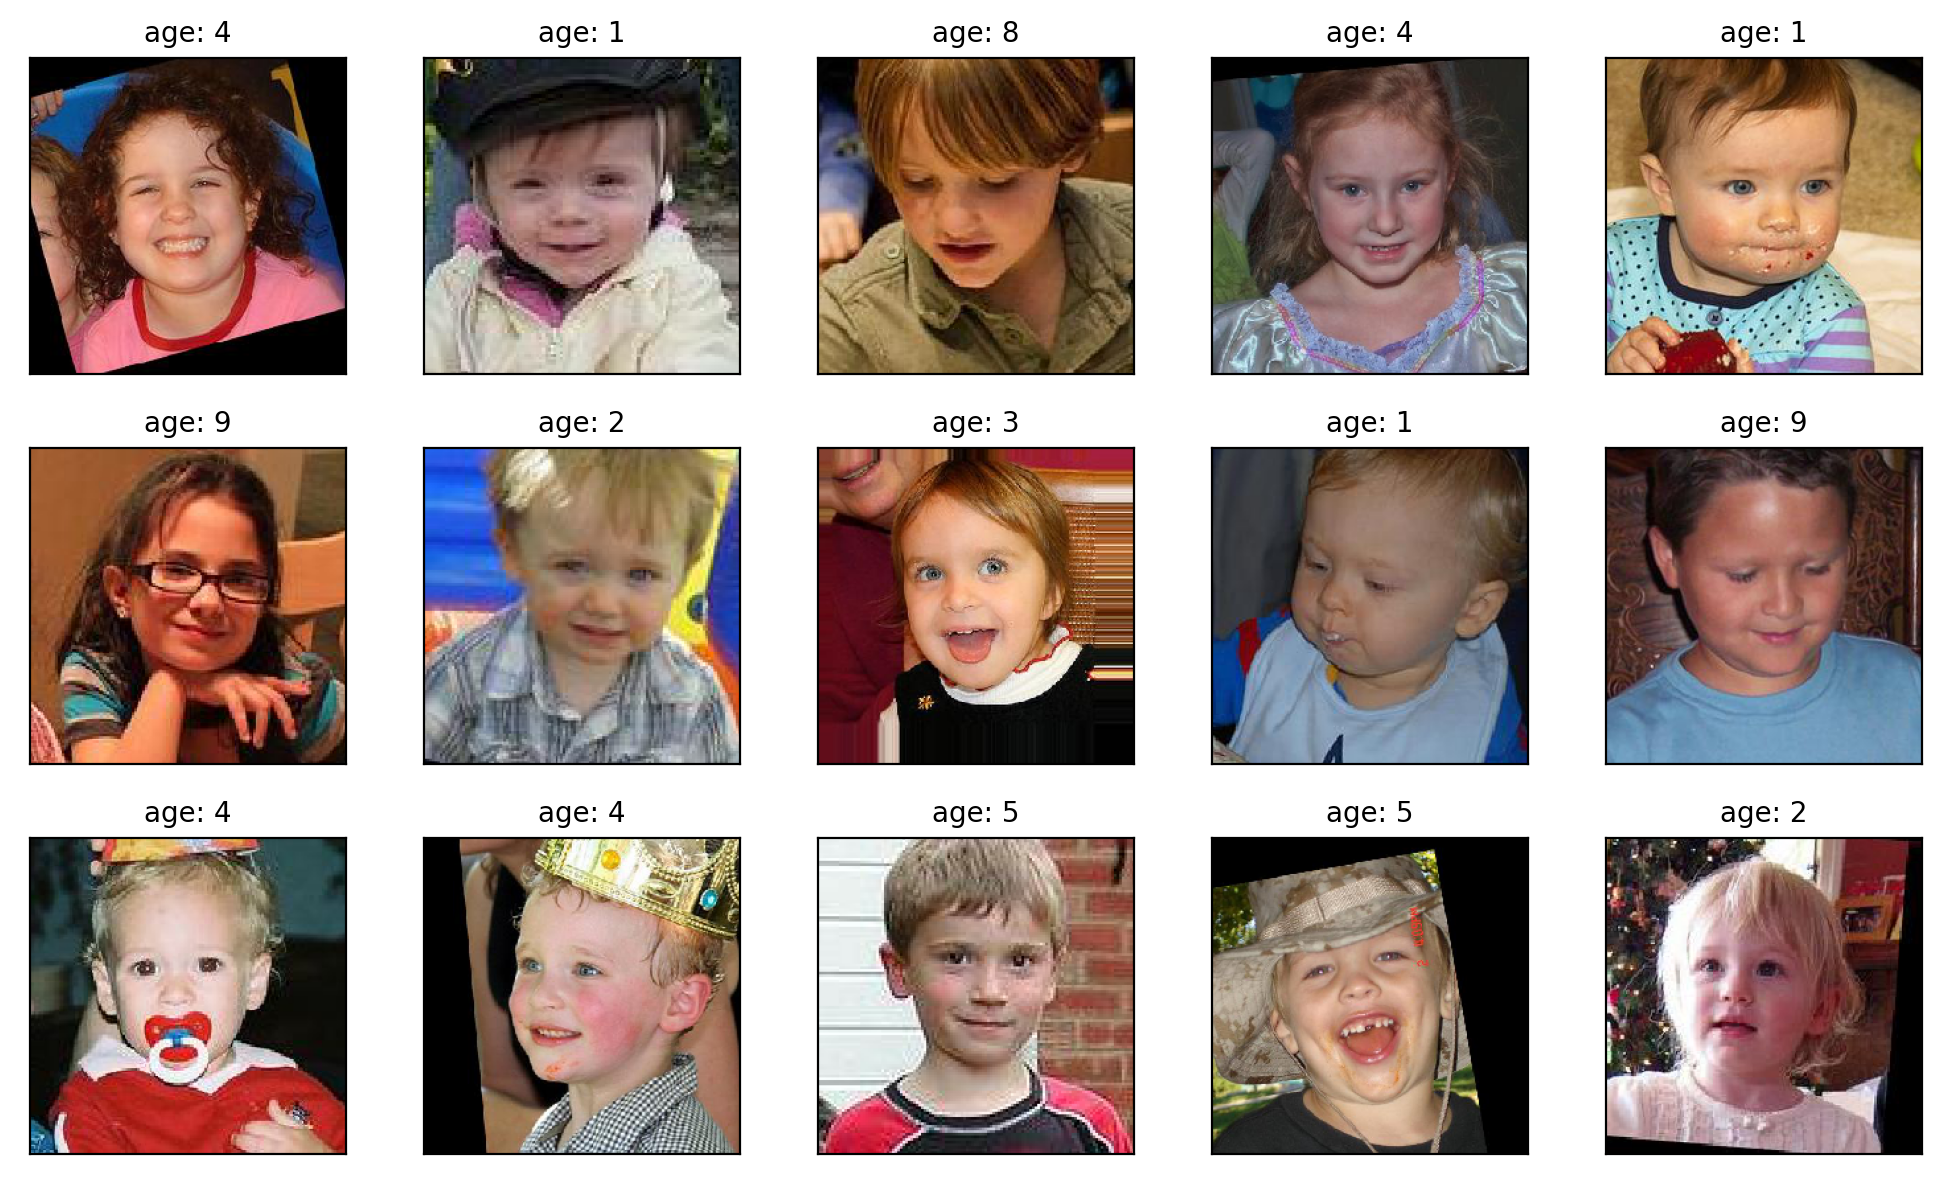

In [18]:
show_batch(next(datagen_flow_0_9))

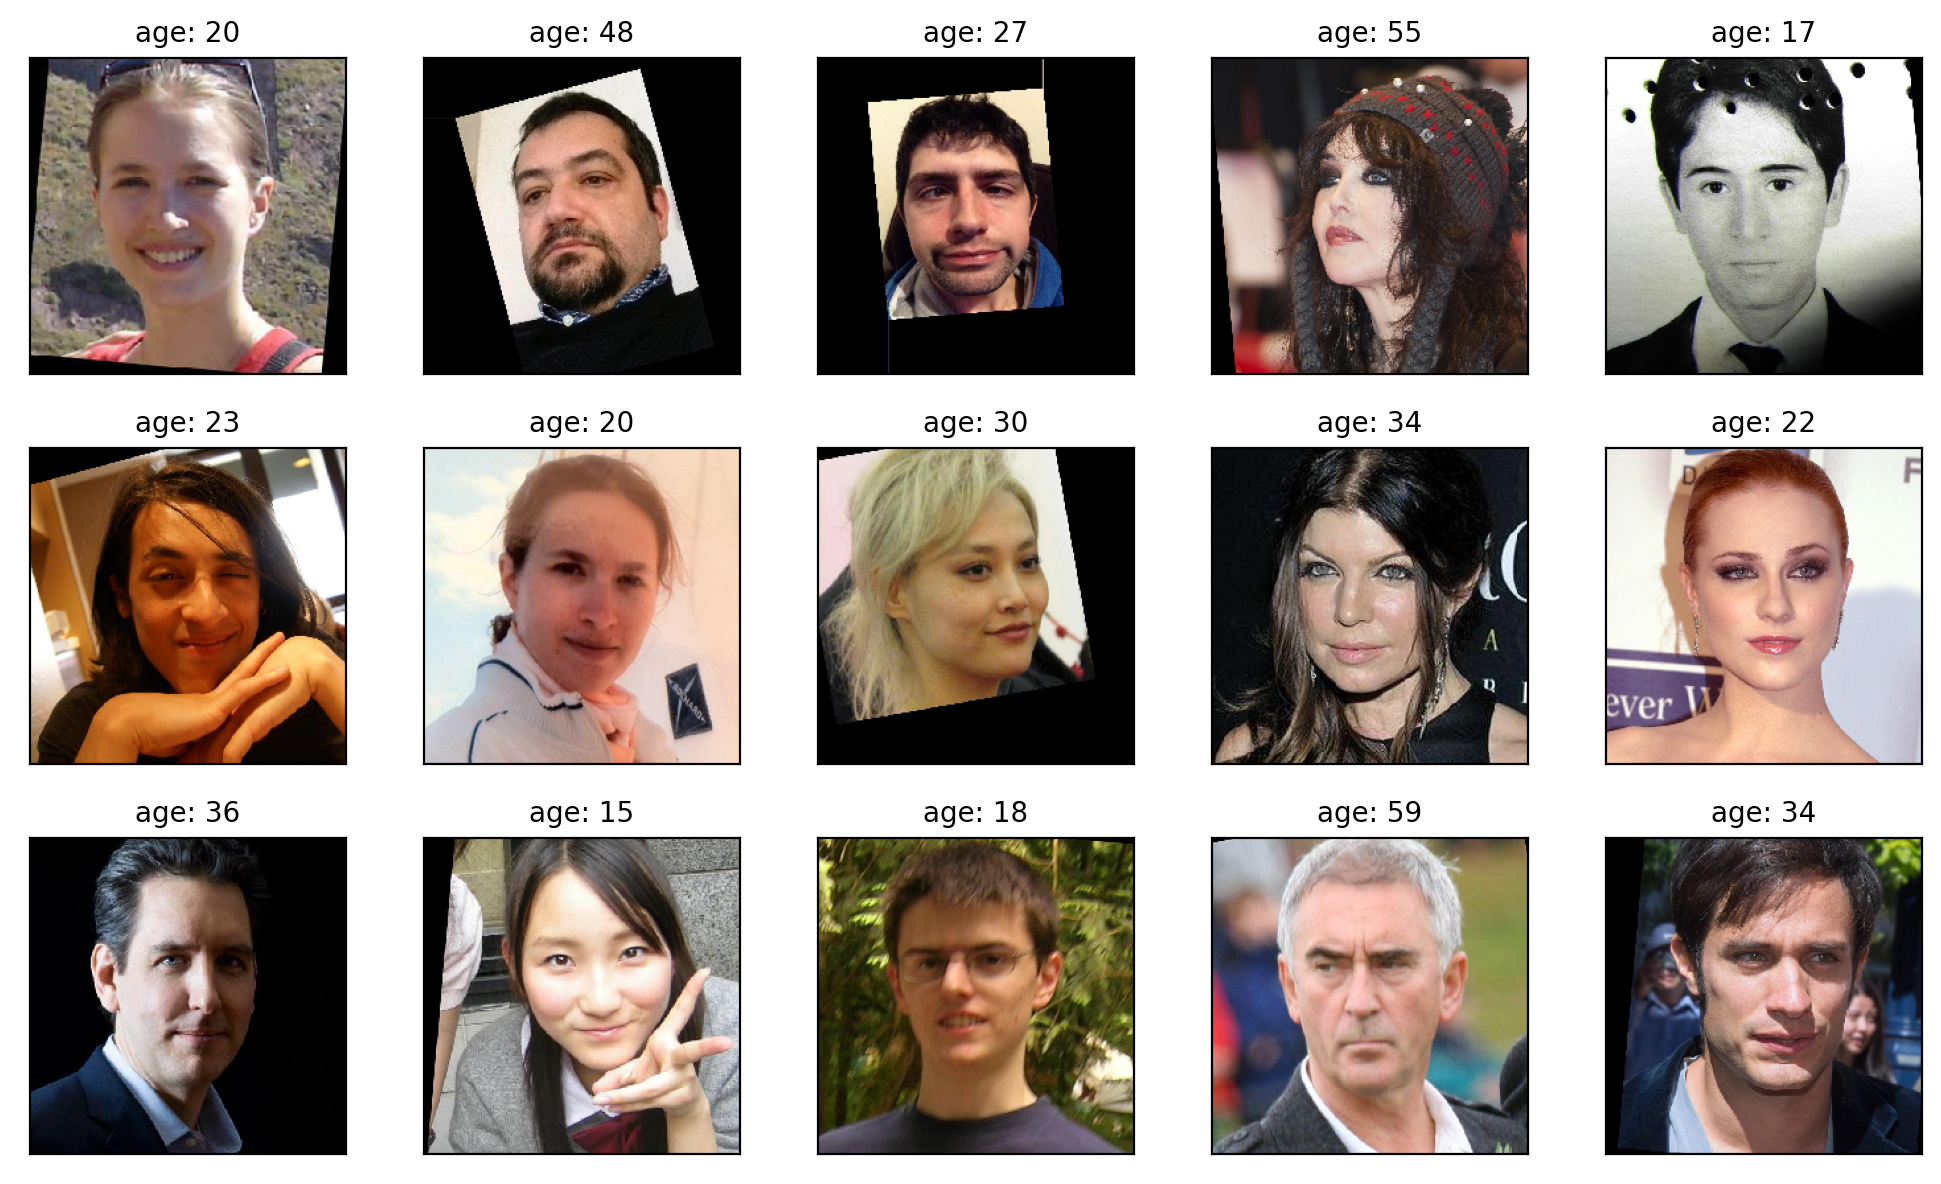

In [19]:
show_batch(next(datagen_flow_10_79))

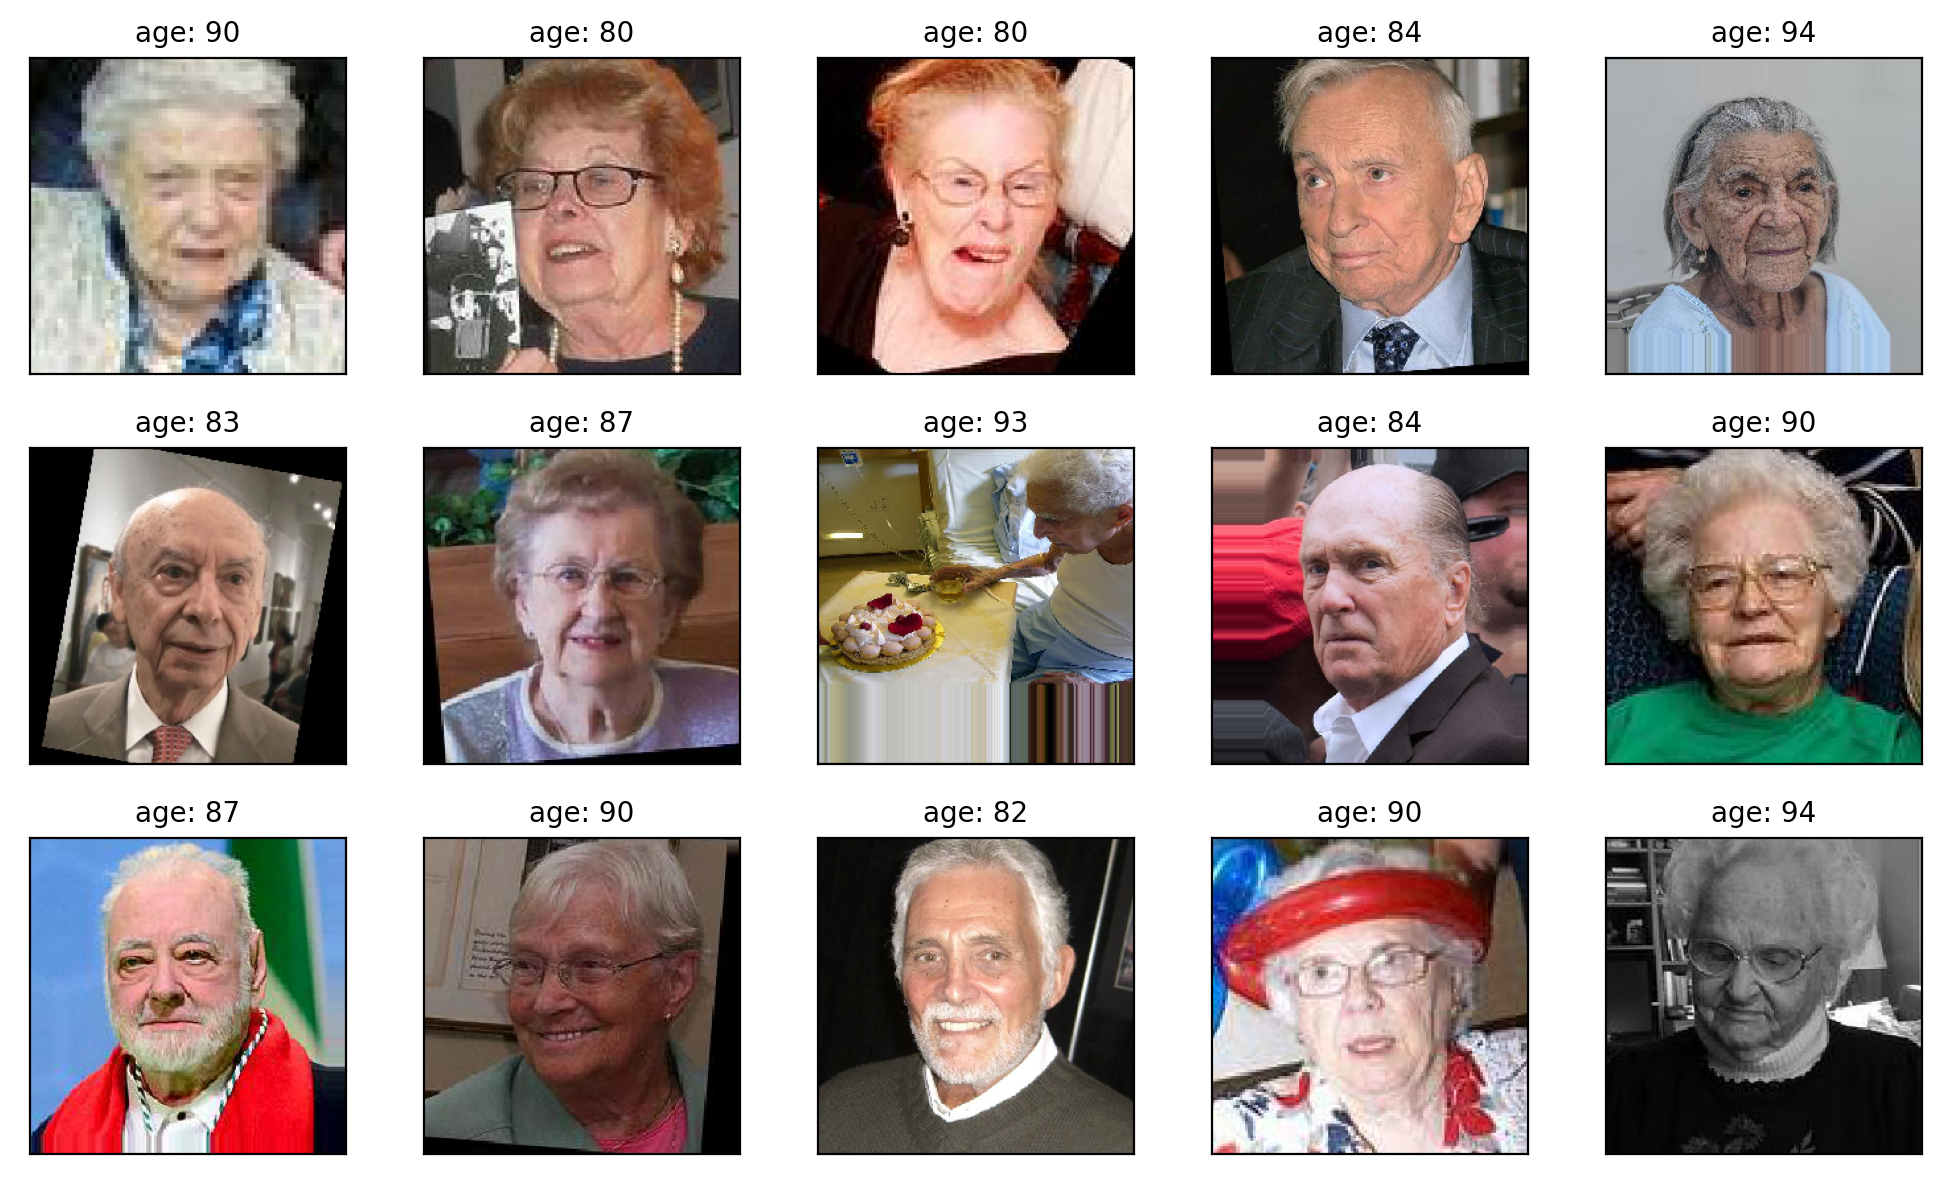

In [22]:
show_batch(next(datagen_flow_80_100))

### Conclusiones

1. Se puede observar que hay muy pocas personas mayores, teniendo como punto inicial a partir de los 60 años.

2. La edad mas representativa está en el rango de los 20 a 30 años, siendo el año 30 y 25 los que más se ven.

3. Los conjuntos de edad más presentes son los de 20-30 años y de 30-40 años, los más pocos son las personas de tercera edad (por encima de los 60 años) y los niños de 0-10 años, de los cuales la mayoría de este conjunto es la edad de 4 años.

4. Con respecto a la calidad de las fotos, hay unas que tienen más brillo y contraste que otras, lo cual a nuestro parecer puede repercutir no tanto en decadas, pero si en años cercanos.


## Modelado

Define las funciones necesarias para entrenar tu modelo en la plataforma GPU y crea un solo script que las contenga todas junto con la sección de inicialización.

Para facilitar esta tarea, puedes definirlas en este notebook y ejecutar un código listo en la siguiente sección para componer automáticamente el script.

Los revisores del proyecto también verificarán las definiciones a continuación, para que puedan comprender cómo construiste el modelo.

In [23]:
import pandas as pd

import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers 

In [24]:
gpus = tf.config.list_physical_devices('GPU')

if gpus:
    try:
        tf.config.experimental.set_virtual_device_configuration(
            gpus[0],
            [tf.config.experimental.VirtualDeviceConfiguration(memory_limit = 1024 * 8)])
    except RuntimeError as e:
        print(e)
        
logical_gpus = tf.config.list_logical_devices('GPU')
print(len(gpus), 'GPU FISICO,', len(logical_gpus), 'GPU LOGICO')

0 GPU FISICO, 0 GPU LOGICO


2023-08-31 01:05:24.422161: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [25]:
%%time

def load_train(path):

    labels = pd.read_csv(path + 'labels.csv')
    train_datagen = ImageDataGenerator(rescale = 1/255, 
                                       validation_split = 0.25, 
                                       horizontal_flip = True)
    train_datagen_flow = train_datagen.flow_from_dataframe(
        dataframe = labels,
        directory = path + 'final_files/',
        x_col = 'file_name',
        y_col = 'real_age',
        target_size = (224, 224),
        batch_size = 4,
        class_mode = 'raw',
        subset = 'training',
        seed = 42
    )

    return train_datagen_flow


CPU times: user 4 µs, sys: 1 µs, total: 5 µs
Wall time: 7.15 µs


In [26]:
%%time

def load_test(path):
    
    labels = pd.read_csv(path + 'labels.csv')
    train_datagen = ImageDataGenerator(rescale = 1/255,
                                       validation_split = 0.25)
    train_datagen_flow = train_datagen.flow_from_dataframe(
        dataframe = labels,
        directory = path + 'final_files/',
        x_col = 'file_name',
        y_col = 'real_age',
        target_size = (224, 224),
        batch_size = 4,
        class_mode = 'raw',
        subset = 'validation',
        seed = 42    
    )

    return train_datagen_flow


CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 7.39 µs


In [27]:
%%time

def create_model(input_shape):
    
    backbone = ResNet50(weights = 'imagenet',
                        input_shape = input_shape,
                        include_top = False)
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(units = 64, activation = 'relu'))
    model.add(Dropout(0.2))
    model.add(Dense(units = 1, activity_regularizer = regularizers.l2(0.01), activation = 'relu'))
    optimizer = Adam(lr = 0.0001)
    model.compile(optimizer, loss = 'mean_squared_error', metrics = ['mae'])

    return model

CPU times: user 4 µs, sys: 1e+03 ns, total: 5 µs
Wall time: 7.63 µs


In [28]:
%%time

def train_model(model, train_data, test_data, batch_size=None, epochs=5,
                steps_per_epoch=None, validation_steps=None):

    model.fit(train_data,
              validation_data = test_data,
              batch_size = batch_size,
              epochs = epochs,
              steps_per_epoch = steps_per_epoch,
              validation_steps = validation_steps,
              verbose = 2,
              shuffle = True)

    return model

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 7.39 µs


In [29]:
model = create_model((150, 150, 3))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 5, 5, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 64)                131136    
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 23,718,913
Trainable params: 23,665,793
Non-trainable params: 53,120
_______________________________________

/opt/conda/lib/python3.9/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


## Prepara el script para ejecutarlo en la plataforma GPU

Una vez que hayas definido las funciones necesarias, puedes redactar un script para la plataforma GPU, descargarlo a través del menú "File|Open..." (Archivo|Abrir) y cargarlo más tarde para ejecutarlo en la plataforma GPU.

Nota: el script debe incluir también la sección de inicialización. A continuación se muestra un ejemplo.

In [ ]:
%%time

# prepara un script para ejecutarlo en la plataforma GPU

init_str = """
import pandas as pd

import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam



"""

import inspect

with open('run_model_on_gpu.py', 'w') as f:
    
    f.write(init_str)
    f.write('\n\n')
        
    for fn_name in [load_train, load_test, create_model, train_model]:
        
        src = inspect.getsource(fn_name)
        f.write(src)
        f.write('\n\n')

In [30]:
train_data = load_train('/datasets/faces/')
test_data = load_test('/datasets/faces/')
model = create_model((150, 150, 3))

Found 5694 validated image filenames.
Found 1897 validated image filenames.


In [ ]:
%%time

model = train_model(model, train_data, test_data)

Epoch 1/5


### El resultado

Coloca el resultado de la plataforma GPU como una celda Markdown aquí.

## Conclusiones

**1. Cargar los Datos**

A. Nos topamos con un conjunto de datos grande, de mas de 7000 entradas.
B. No se encontraron valores duplicados ni ausentes, lo cual se procedio rapidamente a realizar el EDA.

**2. EDA**

A. El conjunto de edades que mas se muestran van desde los 20 a 40 años, mientras que los que menos se muestran son los de la tercera edad, tomando como inicio los 60 años hasta los 100. Los niños se ven poco, pero no tanto como la tercera edad.

B. Quizas el conjunto de datos fue programado para que salieran personas del conjunto de edades anteriormente expuestos, al haber muchas diferencias entre los adultos contra la tercera edad y niños.

**3. Resultado del modelo**

A. Se obtuvieron unos buenos resultados con el modelo, teniendo un MAE por debajo de 8, especificamente de 7.58.

B. En las primeras epocas, que se escogieron 5, tanto la pérdida como el MAE van disminuyendo considerablemente, lo cual nos da a entender que los procesos del modelo van agarrando forma a los datos de entrenamiento.

c. Tenemos unos resultados de una pérdida aceptables dentro del modelo, añadiendo activity_regularizer y el proceso Adam para reducir y generalizar los datos.

D. Al tener en cuenta que tener un MAE por debajo de 6 es muy bueno, siendo el más bajo de 5.4, creemos que el resultado que nos dio es uno bueno, a pesar que el conjunto de datos no ofrezca mucha información sobre las fotografías para determinar con mayor exactitud las edades de las personas.



# Lista de control

- [ ]  El Notebook estaba abierto 
- [ ]  El código no tiene errores
- [ ]  Las celdas con el código han sido colocadas en el orden de ejecución
- [ ]  Se realizó el análisis exploratorio de datos 
- [ ]  Los resultados del análisis exploratorio de datos se presentan en el notebook final 
- [ ]  El valor EAM del modelo no es superior a 8 
- [ ]  El código de entrenamiento del modelo se copió en el notebook final 
- [ ]  El resultado de entrenamiento del modelo se copió en el notebook final 
- [ ] Los hallazgos se proporcionaron con base en los resultados del entrenamiento del modelo